# Neural networks

For this assignment we will implement a basic neural network. The notation used for this in *Alpaydin* is good to help you understand the correlation between a single perceptron and linear discrimination functions, and to understand the derivates that are the basis for backpropagation in a neural network. However, it does not contain enough information to actually build a complete multilayer perceptron.

For this we will use a different notation, also used by *Andrew Ng* in his videos. The benefit of this notation is that is complete, and thus translating it to data operations for the implementation is relatively straightforward. Also the notation lends itself well to using matrix multiplications, meaning a lot of the operations can actually be simplified to a couple of efficient steps.

This does however mean it might take some figuring out how to map the equations from *Alpaydin* to the equations here. Mostly this will just be separating the steps in a different way and using different indices, but as stated, this will make implementing a lot easier. Plus, neural networks can be somewhat unintuitive in the beginning, so having another perspective might help make things click in your own neural network. To aid you during your work, we have written a small set of tests (in the form of assertions) that should show you wether your solution is working as intended.

## Perceptron

Lets start by zooming in on the parameters for just one node in the *Neural Network*.

There are many different types of activation function you can use in a *Neural Network*, but the *Sigmoid* activation function is the classic and most common type. If you use this activation function for a single node perceptron, the combined equations will correspond exactly with the *Logistic Regression* model from Chapter 10.

Watch these 2 videos for the idea behind *Logistic Regression* for classification or why the *Sigmoid* function is used for this.

Learning a classification function


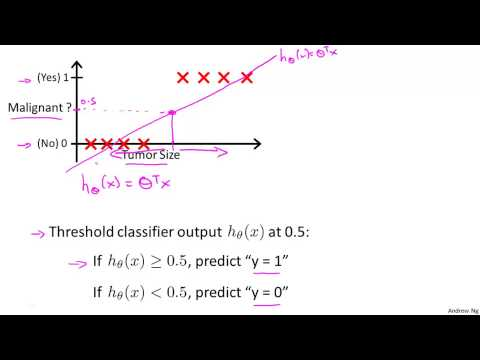

Learning a classification function


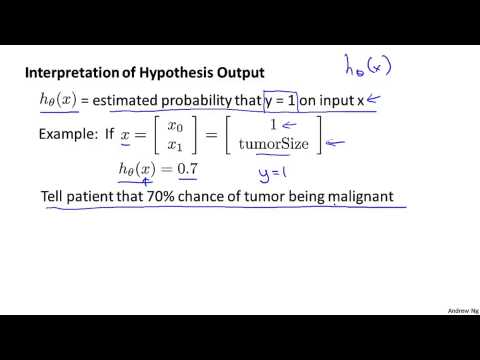

In [31]:
from IPython.display import YouTubeVideo

print('Learning a classification function')
display(YouTubeVideo('K5oZM1Izn3c'))

print('Learning a classification function')
display(YouTubeVideo('WiDuvuM1JyI'))

### Sigmoid Function [1 pt]

The sigmoid function is defined as:

$$g(x) = \frac{1}{1 + e^{-x}} $$

Write the function `sigmoid_func` that can either take a single value `X`, or an array of values `X`, and compute the *Sigmoid* function for each.

*Hint: Numpy built-in functions and basic arithmetic operations work on both Numpy arrays and single values.*

In [32]:
import numpy as np

def sigmoid_func(X):
    return 1 / (1 + np.exp(-X))

assert sigmoid_func(0) == 0.5
assert sigmoid_func(1) == np.e / (1 + np.e)
assert np.allclose(sigmoid_func(np.array([0,1])), np.array([0.5, np.e/ (1 + np.e)]))

### Adding a bias node  [1 pt]

The model for *Logistic Regression* as given by *Alpaydin* is

(10.37) $$y^t = \frac{1}{1 + e^{-(w^T x^t + w_0 )}}$$

This model can compute every $y^t$ value for a some matrix of $X$ values, however, as you might have noticed in the *Logistic Regression* video, there is an alternative. If we expand the matrix $X$ with a column that holds $1$ values used for the bias inputs, just like with the *Polynomial Regression* $D$ matrix, then the equation simplifies to:

$$y^t = \frac{1}{1 + e^{-w^T x^t}}$$

By redefining $x = [1, x^T]^T = [1, x_1, x_2, \ldots, x_d]^T$ and $w = [1, w^T]^T = [w_0, w_1, w_2, \ldots, w_d]^T$

And the model for a single perceptron node (assuming 3 input variables) now becomes:

 <img src="NN_percep.png" width="60%"> 

Note that given some vector of weights $w$ and a matrix of inputs $X$, computing $w^T x^t$ for **all** of the $X$ rows just be becomes a single matrix multiplication. Given that your `sigmoid_func` can also handle array inputs, transforming this array into an array of *Sigmoid* function outputs should also just be a single function call. Doing each of the steps of the computation efficiently is a key component is building a *Neural Network*.

Write the function `add_bias`, which takes a matrix of `X` values, and returns that same matrix with a column of ones added to the front. Take a look at [`np.concatenate`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html).

In [33]:
def add_bias(X):
    return np.concatenate((np.ones((X.shape[0],1)), X), axis=1)

assert np.allclose(add_bias(np.array([[0],[1],[2],[3]])), [[1,0],[1,1],[1,2],[1,3]])

## Expanding to a single layer of nodes

Until now we have only considered individual node outputs $y^t$, but *Neural Networks* are built from layers of these nodes. Each of these layers consists of a combination of one or more *Sigmoid* nodes. Using multiple nodes on the output layer, it is possible to classify multiple classes, instead of just using $0$ and $1$ outputs on a single node. See the video below for a brief example.

Multiclass classification


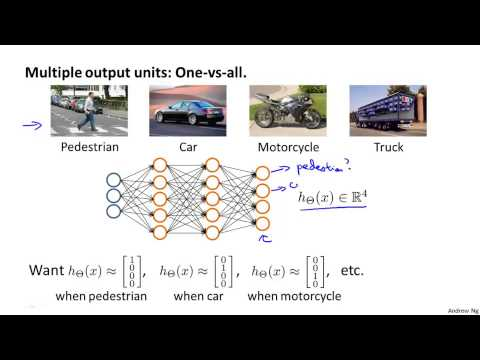

In [34]:
print('Multiclass classification')
YouTubeVideo('HzpptanxP6A')

As each of the these *Sigmoid* nodes will need a set of weights based on their inputs, the weights for a single layer will now be a matrix of shape $(n, m + 1)$; for each node $n$, there are $m + 1$ inputs ($m$ inputs and the bias node).  This matrix will be called $\Theta$, where each row contains the weights for one of the sigmoid nodes. We will start with only a single layer network, but in a complete network this matrix is indexed as follows,

$$\Theta^j_{ki}$$

which is **the weight from $i^{th}$ node in layer $j$ to the $k^{th}$ node in layer $j+1$**. *Note: this indexing might seems counterintuitive, but is convention for a reason, as we will see later.* 

For now, we will only build a single layer network, which means we will only need to define $\Theta^0$. Consider the example single layer network below:

 <img src="NN_single.png" width="50%"> 
 
It has 3 input nodes (+1 bias node) and 3 output nodes, meaning it can learn to distinguish 3 classes based on the value of 3 input variables. The matrix $\Theta^0$ would describe all the weights between the layer 0 nodes and the layer 1 nodes, and thus has dimension $3x4$. For example, $\Theta^0_{03}$ would describe the weight from node 3 in layer 0 (which is $x_3$) to node 0 in layer 1 (which is $A^1_0$).

### Initializing weights [1 pt]

Even if we don't exactly know yet how to compute the corresponding output values, lets start by creating a matrix of the correct dimensions to hold the $\Theta^0$ weights. When creating a *Neural Network*, it important to use random starting values for the weights. This has to do with the fact that we will again use partial derivative to find the optimal values for the model parameters, and want different derivative values for different nodes. For more context on why this useful, you can watch:

Random initialization


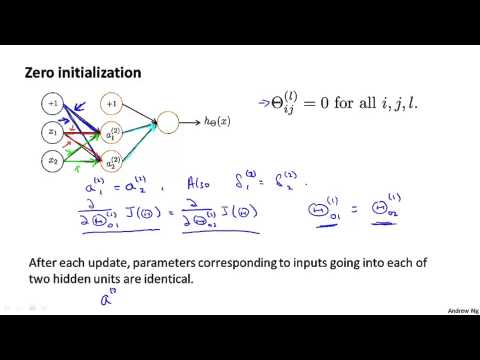

In [35]:
print('Random initialization')
display(YouTubeVideo('NhgB6FLyHJc'))

For now, lets just create a matrix with some random starting values for $\Theta^0$, so we can begin computing outputs for the first layer of the network. Write the function `one_layer_init`, which takes the number of input and output nodes and returns a matrix of weights of the correct dimensions (don't forget to add the bias node). Each weight should be randomly initialized using a uniform distribution over the range $[-0.3, +0.3)$.

In [36]:
def one_layer_init(input_size, output_size):
    return np.random.rand(output_size, input_size+1)*0.6 - 0.3

assert one_layer_init(5, 3).shape == (3, 6)

## Multilayer Network

Now lets start combining these pieces and work on the actual *Neural Network* computation model. **This model will not be able to "learn" just yet, only compute outputs given some inputs and a matrix of weights.**

Hopefully you already have a bit of an idea of what this would look like for a 1 layer network, but here we will build the complete multilayer version, in order to get some sense of the final picture too. Watch these 2 videos on the model representation:

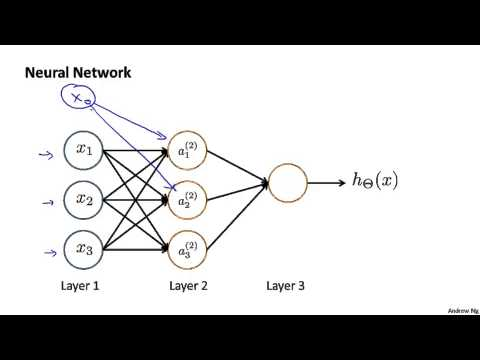

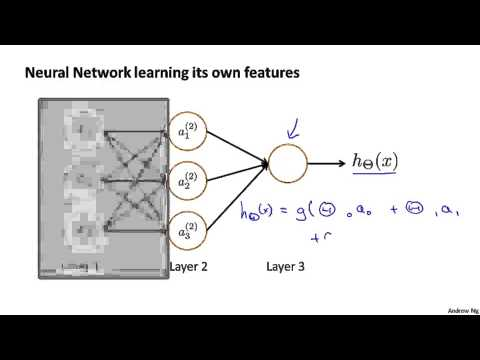

In [37]:
display(YouTubeVideo('wnSol2JRZeY'))
display(YouTubeVideo('vuhueI_7324'))

So, for the multilayer case, the outputs from one layer just become the inputs for the next layer. Completing the system of equations; the activation at the input layer consists of the bias term and the values for each of the input variables.

$$A^0 = [1, x_1, x_2 \dots x_d]$$

The combined input for each next node in the layer j+1 is just the sum of the activations from the previous layer multiplied by their respective weights:

$$Z^{j+1}_k = \sum_i A^j_i\Theta^j_{ki}$$

And then the activation for each of these nodes is computed by simply taking the *Sigmoid* function of the combined node input:

$$A^j_i = g(Z^j_i)$$

which can then again be used as input for the next layer of nodes, until the output layer is reached.

Expanding the single layer example from earlier to a 2 layer network with 1 output node, would look like:

 <img src="NN_multi.png" width="80%">
 
This example now has 3 input nodes (+1 bias node), 3 hidden nodes (+1 bias node) and 1 output node.

An important thing to note is that all these equations are for a single row of input values $x^t$, so they just compute the output for a single sample in the data, whatever the dimensions and weights of the network actually are. In order to make your code more efficient, you should write all these functions to compute their steps on the entire data matrix $X$. In essence that just means repeating the equations for each of $M$ rows in the data set, but in practice it can often be written as some matrix multiplication. This does not only apply to the functions directly below, but to all of the following functions in the assignment. The code to write the functions as matrix operations is actually shorter and more efficient, so take the time to think about if you could avoid writing loops in your code. Drawing the dimensions of the matrices might help with this.

### Computing activations for one layer [1 pt]
We will start by implementing the functions that would be required to compute the activations for a single layer. This includes the calculation of activations of the layer, and the output calculation. For the required equations, refer to the text directly above.

Write a general function `compute_layer`, which takes a matrix for $A^j$ values, where each row represents the activations of the nodes for a different data sample, and matrix $\Theta^j$, defining the connection weights for that layer, and return next the matrix $A^{j+1}$. Try and write this operation as matrix multiplication and remember that you already wrote your *Sigmoid* function (`sigmoid_func`) to also work on Numpy arrays.

In [63]:
def compute_layer(A_j, Theta_j):
    return sigmoid_func(np.dot(A_j, Theta_j.T))

assert np.allclose(compute_layer(np.array([[1,0]]), np.array([[1,2],[0.5,0]])), np.array([[np.e / (1 + np.e), np.e**0.5 / (1 + np.e**0.5)]]))

Next write the function `one_layer_output`, which takes a matrix of training samples $X$ and a matrix of weights $\Theta^0$ and returns a matrix of computed outputs. This function will only need the `add_bias` function from earlier and the `compute_layer` function you just wrote.

In [64]:
def one_layer_output(X, Theta_0):
    A = add_bias(X)
    return compute_layer(A, Theta_0)

assert np.allclose(one_layer_output(np.array([[0]]), np.array([[1,2],[0.5,0]])), np.array([[np.e / (1 + np.e), np.e**0.5 / (1 + np.e**0.5)]]))

### Multilayer initialization and computations [1 pt]

In order to work with multilayer networks, we will need a complete matrix $\Theta$. Write the function `n_layer_init`, which takes a tuple or list named `layer_sizes` that contains the sizes of every layer and returns an array of randomly initialized weight matrices of the correct dimensions to connect each of the layers. E.g. `n_layer_init(layer_sizes=(3, 4))` should create network with 3 inputs and 4 outputs, `n_layer_init(layer_sizes=(2, 5, 1))` should create a network with 2 inputs, 5 hidden nodes, and 1 output, etc. 

Note that you already wrote a random initialization for a weight matrix of a single layer (`one_layer_init`), however, the new function requires multiple matrices to be combined in an array, depending on the number of layers in the network.

In [65]:
def n_layer_init(layer_sizes):
    Theta = []
    for i in range(len(layer_sizes)-1):
        Theta.append(one_layer_init(layer_sizes[i], layer_sizes[i+1]))
    return np.array(Theta)

assert np.allclose([x.shape for x in n_layer_init(layer_sizes=(2, 5, 1))], [(5, 3), (1, 6)])

Now write the function `n_layer_output`, which takes a matrix $X$ and an array of matrices $\Theta$ and returns the final output layer matrix for that network. Remember that $\Theta$ is actually built up out of several $\Theta^j$s and that we already wrote a function (`one_layer_output`) for that!

In [66]:
def n_layer_output(X, Theta):
    for Theta_j in Theta:
        X = one_layer_output(X, Theta_j)
    return X

assert np.allclose(n_layer_output(np.array([[0]]), [np.array([[1,2],[0.5,0]]), np.array([[0,1,0],[0,0,1]])]), [sigmoid_func(np.array([np.e / (1 + np.e), np.e**0.5 / (1 + np.e**0.5)]))])

## Testing with boolean functions [2 pts]

With all this these functions written, it might be a good time to reflect on what it is that such a network would actually compute and what these weights in the network could represent, if anything. A helpful step might be this video, where the weights for simple boolean functions are determined by hand.

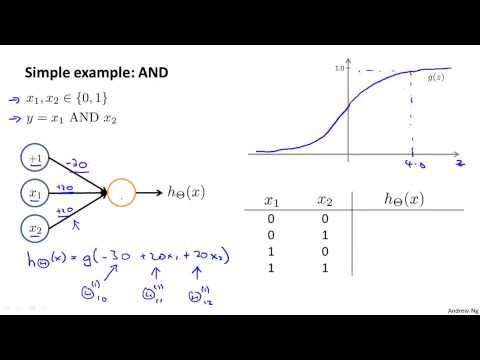

In [67]:
YouTubeVideo('BhWlHvjEn3s')

These boolean functions are some of the easiest problems you can compute on a neural network, and so they are also great for testing. Create a data matrix $X$ containing all 4 possible pairs of boolean input (use $0$ for *False* and $1$ for *True*) and randomly initialize several networks with 2 input nodes and 1 output node. Create a random network with no hidden layers, a random network with 1 hidden layer and a random network with 3 hidden layers. Compute the output for $X$ using each of these and print the results. Note that since these networks are random, the computation results will be random too, but it is still usefull to check for errors, check if the resulting matrix is the right dimension and check if the values in the matrix are in a sensible range.

The tests you just ran where with random weights for each of the layers. Next take the weights given for the **AND** function in the video and put them directly in a matrix $\Theta^0$. Think about where each of these weights should go in your matrix $\Theta^0$ and create that matrix manually. Compute the output for $X$ using this matrix and show the results. Do they look like you would expect?

In [68]:
X = np.array([[0,0],[0,1],[1,0],[1,1]])

for layers in [[2,1], [2, 3, 1], [2, 3, 5, 3, 1]]:
    print(len(layers)-1, "layers:", layers)
    Theta = n_layer_init(layer_sizes=layers)
    print(np.round_(n_layer_output(X, Theta), decimals=4))

print("Handcoded weights AND")
Theta_0 = np.array([[-30, 20, 20]])
print(np.round_(one_layer_output(X, Theta_0), decimals=4))

1 layers: [2, 1]
[[0.4946]
 [0.5509]
 [0.4298]
 [0.4858]]
2 layers: [2, 3, 1]
[[0.5389]
 [0.5436]
 [0.5431]
 [0.5477]]
4 layers: [2, 3, 5, 3, 1]
[[0.5119]
 [0.5119]
 [0.5118]
 [0.5118]]
Handcoded weights AND
[[0.]
 [0.]
 [0.]
 [1.]]


## Learning with one layer

Now we have a model capable of computing outputs, given a set of inputs and weights. An interesting question is if we can modify these weights to model an existing relationship between the input and output in some training data. For example, if we could find the parameters for the **AND** function *computationally* based on training samples of input and output.

Recall from the start of the assignment that each single node in the network corresponds to a *Logistic Regression* model. We could therefore try to take the same approach to optimize the weights of the network as with *Logistic Regression*, and apply *Gradient Descent*. 

### Gradient Descent

In *Gradient Descent* we incrementally change the weights to improve the fit on our training samples according to the cost function. The easiest case to understand what *Gradient Descent* actually does is in the case of *Linear Regression*. This is the first machine learning algorithm you built, in week 1 of the course. In the exercise of that week, we solved at what point the partial dervatives of the cost function for the parameters $\theta_0$ and $\theta_1$ were 0. This type of analytical solution is possible for simple models, but not for more complex ones. In the case of *Linear Regression* we could also have used *Gradient Descent* to incrementally move $\theta_0$ and $\theta_1$ in the direction of the gradient and eventually settle on the same minimal cost solution. These videos can really help to build intuition on what gradient descent actually does:

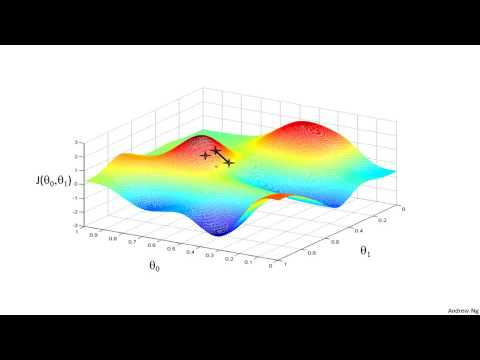

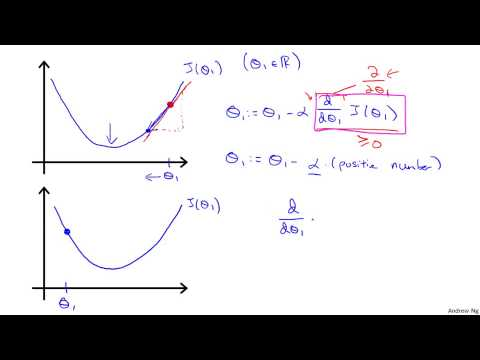

In [69]:
display(YouTubeVideo('P3K38HusyV4'))
display(YouTubeVideo('4SVqZaY55qo'))

### The cost function [2 pts]

*Gradient Descent* works exactly the same for more complex models like *Logistic Regression* or *Neural Networks*, as long as there is some function to compute the output and a cost function to optimize. The function for the classification error is defined as:

$$J(\Theta) = - \sum_{i=1}^M \sum_{k=1}^K Y^i_k log(H_\Theta(X^i)_k) + (1 - Y^i_k) log(1 - H_\Theta(X^i)_k)$$

which is the sum of the classification error for all $M$ training samples and all $K$ different outputs, when comparing the current output of the network $H_\Theta(X^i)_k$ to the target output $Y^i_k$. The video on the topic, if you want a more detailed breakdown, can be found here (note you may ignore the regularization term covered there):

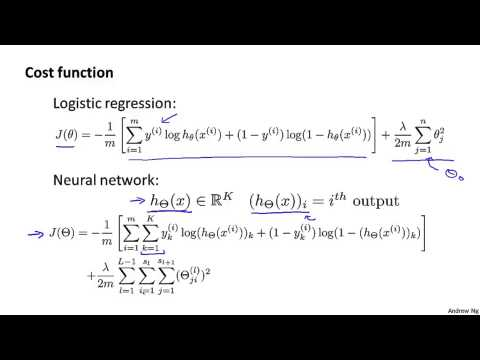

In [70]:
YouTubeVideo('18X68kLAfKY')

Write the function `cost_function`, which takes a matrix $A = H_\Theta(X)$ with the network activations at the output layer (rows are outputs for different training samples, columns are the different output nodes) and a matrix $Y$ of the same dimensions containing the training targets, and computes the total classification error.


In [71]:
def cost_function(A, Y):
    return -1*np.sum(Y * np.log(A) + (np.ones(Y.shape) - Y) * np.log(np.ones(A.shape) - A))

assert np.allclose(cost_function(np.array([[.1,.9],[.9,.1]]), np.array([[0,1],[1,0]])), 0.4214420626313051)

### Delta Terms [1 pt] 

Now we need take the partial derivatives of this cost function for each of the $\Theta$ parameters of our network, so we can start changing them to minimize the cost function. These gradients will be computed in 2 separate steps. First we define a term $\delta$ that contains the partial derivatives of the cost function with respect to the nodes input

$$\delta^j_i = \frac{\partial J}{\partial Z^j_i}$$

which is defined for each $i^{th}$ node in each $j^{th}$ layer. Computing this term separately will make the complete multilayer version much easier to write. For an output layer, i.e. when $j$ is the last layer in the network, the delta term is defined as:

$$\delta^j_i = A^j_i - Y_i$$

Note that, as before, this is again an equation which is defined for a **single sample** of input values and output values, i.e. the indices *do not* relate to the different training samples, only the node location in the network. So, $Y_i$ is just the $i^{th}$ target output (in the case of multi-class classification) for a single sample and the equation will compute a single $\delta$ value for $i^{th}$ node in the $j^{th}$ layer. If this process would be again repeated for each of the training samples, $\delta^j_i$ would be an array of values, each row corresponding to $\delta^j_i$ for one of the samples. 

Write the function `output_delta` which takes a complete matrix $A^j$ with all the network activations at layer $j$ (rows are outputs for different training samples, column are the different output nodes) and a matrix $Y$ (the same dimensions) containing the training targets, and computes the $\delta^j$ terms at the output layer for every sample. This should be a matrix of the same dimensions, with a separate $\delta$ term for each training sample, for every output node.


In [72]:
def output_delta(A_j, Y):
    return A_j - Y

assert np.allclose(output_delta(np.array([[0,1],[0,1]]), np.array([[0,1],[1,0]])), np.array([[0,0], [-1, 1]]))

### Computing the weight updates [2 pts]

With these $\delta$ terms computed, we can now compute the derivates with respect to the $\Theta$ parameters of the network

$$\frac{\partial J}{\partial \Theta_{ki}^j} = \sum_{d=1}^M (\delta^{j+1}_k)^{d}(A^j_i)^d$$

This is where all the different values for $\delta^{j+1}_k$ and $A^j_i$ for each sample are combined into a single gradient value for $\Theta_{ki}^j$. The sum here is over $d=1$ to $M$ (assuming there are $M$ different training samples) and $(\delta^{j+1}_k)^{d}$ and $(A^j_i)^d$ are the delta values and node activations for the $d^{th}$ training sample respectively.

Summing these values over all $M$ training samples will result in the overall gradient on the cost function for $\Theta_{ki}^j$, meaning this will be *Batch Gradient Descent*. The actual update to the weights is then just the standard *Gradient Descent* rule:

$$\Theta^j_{ki} = \Theta^j_{ki} - \alpha\frac{\partial J}{\partial \Theta_{ki}^j}$$

Write the function `weight_update`, which should compute these values for the weights of 1 layer, i.e. a matrix $\Theta^j$. It should return the new value for $\Theta^j$, given the old matrix $\Theta^j$, the activations matrix $A^j$ in at the layer $j$ (again, rows for different training samples, column are the different nodes in the layer), the $\delta^{j+1}$ matrix for the next layer $j+1$, called `Delta_next` and the learning rate $\alpha$, called `rate`.


In [90]:
def weight_update(A_j, Delta_next, Theta_j, rate):
    return Theta_j - rate * np.dot(Delta_next.T, A_j)

assert np.allclose(weight_update(np.array([[0,1],[0,1]]), np.array([[0,1],[1,0]]), np.array([[0,1],[1,0]]), 1.0), np.array([[0,0], [1, -1]]))

In the case of a *Neural Network* with just 1 layer, this `weight_update` function will compute all the updated weights in a single step. Here `A_j` would refer to $A^0$, i.e. the activations at the input layer, and `Delta_next` would be the $\delta$ terms for the output layer.

### Training the single layer network [2 pts]

Now, given some training data, we just repeatedly compute the network outputs for each of the training inputs, then compute the deltas based on the training outputs, and finally update the weights. For every step of this repeated  computation, the weights should fit the training data slightly better and classification error on the training set should slowly decrease to a minimum. At that point the network should be able to reproduce the training outputs with an as low as possible error.

Write the function `one_layer_training`, which takes a data set consisting of matrices `X` and `Y`, and a weight matrix `Theta_0` with some initial values. Additionally, the function takes 2 optional parameters; `iters` to indicate the number of iterations gradient descent should be repeated for, and `rate` to specify the learning rate that should be used for the updates. The function should then perform *Gradient Descent* on this data set, and store the value of the cost function at every step. 

Remember the steps required:
1. Create $A_0$ by adding a bias node (`add_bias`)
2. Repeat `iter` times:
    1. Compute the outcome of the layer with `compute_layer`
    2. Get the $\delta$ terms for the output layer with `output_delta`
    3. Update $\Theta_0$ through `weight_update`

At the end the function should plot a graph showing the error decreasing (on the y-axis, the x-axis is just a count of the iterations) and function should return the learned values for weight matrix `Theta_0`.

In [82]:
import matplotlib.pyplot as plt

def one_layer_training(X, Y, Theta_0, iters=1000, rate=0.9):
    A0 = add_bias(X)
    C = []
    
    for i in range(iters):
        A1 = compute_layer(A0, Theta_0)
        D = output_delta(A1, Y)
        Theta_0 = weight_update(A0, D, Theta_0, rate)
        C.append(cost_function(A1, Y))
        
    plt.plot(C)
    plt.show()

    return Theta_0

### Learning boolean functions [2 pts]

Lets now try and learn some boolean functions using our single layer network, to test if training procedure works. Some boolean functions might be harder to learn than others, so it will be interesting to see what the network can and can't learn. Watch this video on the classic XOR problem.

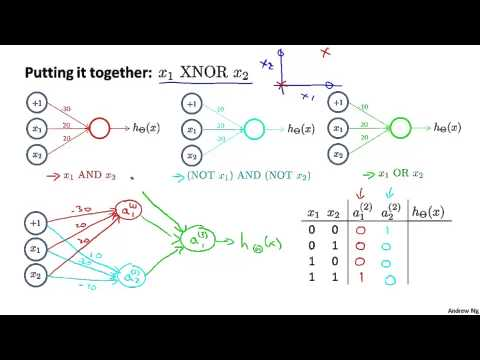

In [83]:
YouTubeVideo('QZqmNpEyiKI')

Create 3 training sets for the boolean functions: *AND*, *OR* and *XOR*, and train 1 layer networks (2 inputs, 1 output) for each of the these problems. Each problem has the same 4 possible input combinations for 2 boolean variables. The output variable should change based the specific function you are trying to learn.

Show the plots of the cost function decreasing for each problem and show the final 4 computed outputs for each function too. Do these results match what you would expect?


AND


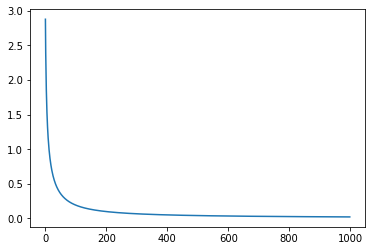

[[0.  ]
 [0.01]
 [0.01]
 [0.99]]

OR


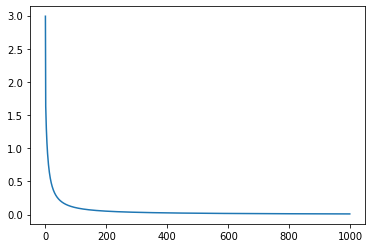

[[0.01]
 [1.  ]
 [1.  ]
 [1.  ]]

XOR


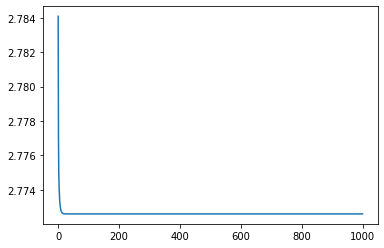

[[0.5]
 [0.5]
 [0.5]
 [0.5]]



In [84]:
Y_sets = [("AND",  np.array([[0], [0], [0], [1]])),
         ("OR",  np.array([[0], [1], [1], [1]])),
         ("XOR",  np.array([[0], [1], [1], [0]]))]

for label, Y in Y_sets:
    print(label)
    Theta_0 = one_layer_training(X, Y, one_layer_init(2,1))
    print(np.round_(one_layer_output(X, Theta_0), decimals=2))
    print()

## Backpropagation [1 pt]

Until now we have only been training single layer networks, where the gradient was easily computed using the error at the output nodes. The *Backpropagation* algorithm extends this by also computing error terms at the hidden nodes and thus being able to update multilayer network weights in the direction of the gradient too.

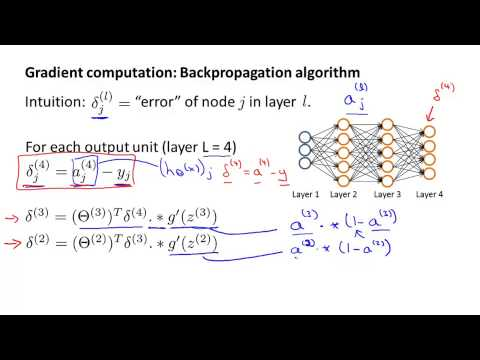

In [85]:
YouTubeVideo('SvAEX5taVKk')

Most of the functions you already wrote are still useful in the complete *Backpropagation* algorithm, the only real change is that there is now a delta term for hidden nodes too.

$$\delta^j_i = (1 - A^j_i)A^j_i \sum_k \delta^{j+1}_k\Theta^j_{ki} $$

These deltas take the deltas at the next layer and propagate them backwards, which is where the algorithm gets its name. The deltas for the output layer and the gradient descent update of the weights remain exactly the same as for the single layer network.

Once the deltas at the output layer are computed based on the difference between the computed outputs and the target outputs, we can compute deltas for the layer before it, carrying part of the error to the previous layer. Then we can use those det ltas to compute the deltas for the layer before that, and so on, all the way to the first layer of the network. These delta values for the hidden nodes can be used to compute the updates for weights in exactly the same way as for the output nodes.

Write the function `hidden_delta`, which computes the matrix of $\delta$ values for 1 hidden layer, where each row corresponds to the deltas for a different training sample and the columns corresponds to each of the nodes in that hidden layer. It should take as input the activations at that layer $A^j$, the $delta$ values for the next layer and the matrix of weights connecting them, $\Theta^j$.

In [86]:
def hidden_delta(A_j, Delta_next, Theta_j):
    return (np.ones(A_j.shape) - A_j) * A_j * np.dot(Delta_next, Theta_j)

assert np.allclose(hidden_delta(np.array([[1,.9],[0.8,.9]]), np.array([[0,1],[.9,0.9]]), np.array([[1,1],[.2,0.9]])), np.array([[0.,0.081],[0.1728,0.1539]]))

### Training 2 layers [2 pts]

Now all that remains is to combine these functions into a multilayer network. These videos should help get an overview of the pieces you need:

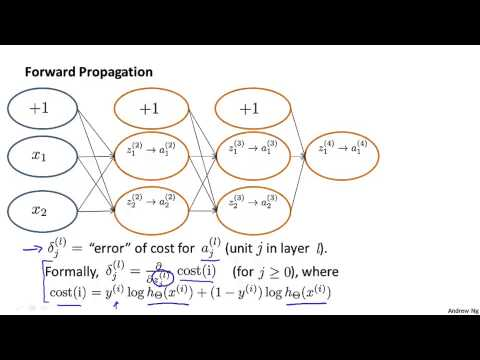

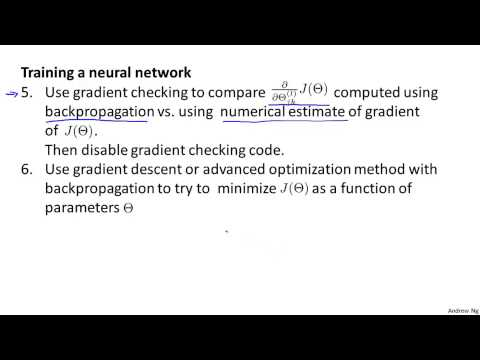

In [87]:
display(YouTubeVideo('q1bQDyV6lsg'))
display(YouTubeVideo('T7-ZsYlFH4M'))

Write the function `two_layer_training`, which should work exactly like the function `one_layer_training`, except that it takes 2 weight matrix arguments $\Theta^0$ and $\Theta^1$. The argument $\Theta^0$ should contain the weights connecting the input layer to the hidden layer and $\Theta^1$ should contain the weights connecting the hidden layer to the output layer. Additionally, the function takes 2 optional parameters; `iters` to indicate the number of iterations gradient descent should be repeated for, and `rate` to specify the learning rate that should be used for the updates. The function should then perform *Gradient Descent* on this data set, and store the value of the cost function at every step. 

Remember the steps required:
1. Create $A_0$ by adding a bias node (`add_bias`)
2. Repeat `iter` times:
    1. Compute the outcome of the output layer with `compute_layer`; first take the output of the first layer, then add the bias node, and finally compute the output of the second layer.
    2. Get the $\delta$ terms for the layers with `output_delta` and `hidden_delta`; first take the $\delta$ of the output layer, then get the $\delta$ of the hidden layer, and finally remove the $\delta$s corresponding to the bias node from the full $\delta$ matrix of the hidden layer.
    3. Update $\Theta_1$ and $\Theta_0$ through `weight_update`
    
We want to remove the $\delta$s corresponding to the bias node from the $\delta$, because do not want to propagate its error any further; this "bias $\delta$" that is in the second layer had no contribution to the error of the first layer.  This can also be seen when you would try to propagate the full $\delta$, as the size of the weight matrix would not line up.

At the end the function should plot the cost function as it decreases with each iteration and return the computed values for $\Theta^0$ and $\Theta^1$.

In [88]:
def two_layer_training(X, Y, Theta_0, Theta_1, iters=5000, rate=0.9):
    A0P = add_bias(X)
    C = []
    
    for i in range(iters):
        A1 = compute_layer(A0P, Theta_0)
        A1P = add_bias(A1)
        A2 = compute_layer(A1P, Theta_1)
        
        D2 = output_delta(A2, Y)
        D1 = hidden_delta(A1P, D2, Theta_1)
        D1P = D1[:, 1:]
        
        Theta_1 = weight_update(A1P, D2, Theta_1, rate)
        Theta_0 = weight_update(A0P, D1P, Theta_0, rate)
        
        C.append(cost_function(A2, Y))
        
    plt.plot(C)
    plt.show()

    return Theta_0, Theta_1

### Revisiting the boolean functions  [1 pt]

Rerun the tests to learn the 3 boolean functions; *AND*, *OR* and *XOR*, but use 2 layer networks (2 inputs, 2 hidden nodes and 1 output node) this time. Plot the cost function for each problem and show the final computed output for each function.

AND


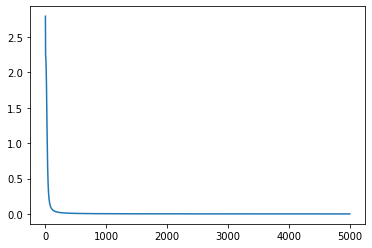

[[0.]
 [0.]
 [0.]
 [1.]]

OR


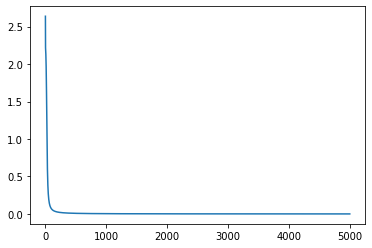

[[0.]
 [1.]
 [1.]
 [1.]]

XOR


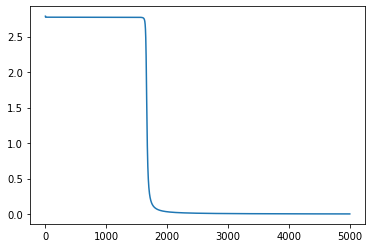

[[0.]
 [1.]
 [1.]
 [0.]]



In [89]:
for label, Y in Y_sets:
    print(label)
    Theta = n_layer_init(layer_sizes=(2,2,1))
    Theta = two_layer_training(X, Y, Theta[0], Theta[1])
    print(np.round_(n_layer_output(X, Theta), decimals=2))
    print()

### Discuss if these results are different from the 1 layer network results and why [2 pts]

...


## Digit recognition

For the last part of this assignment, lets try the algorithm on a more complicated problem, digit recognition. The data for this problem can be found in the file `digits123.csv`. Each row contains 65 values, where the first 64 are greyscale pixel values, and the last value is the class label, corresponding to the digit being shown. The greyscale values are integers ranging from 1 to 16, and using some reshaping, can be reconstructed back into a low-resolution *8x8* image.

Below is the code to show the image for one digit, i.e. the input for one sample in the data set. Run the code to see the image. You can change the `index` variable to visualize different rows from the data set.

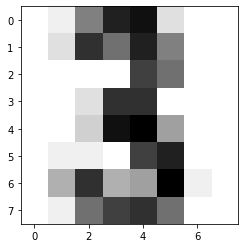

The label for this digit was: 3


In [57]:
digits = np.loadtxt('digits123.csv', delimiter=',', dtype=int)

index=np.random.randint(digits.shape[0])

digit_sample = np.ones((8,8))*16 - np.reshape(digits[index, :-1], (8, 8))
plt.imshow(digit_sample, cmap='gray', vmax=16)
plt.show()
print("The label for this digit was:", digits[index, -1])

### Training your network [4 pts]
Using the digits data and the neural network code you just wrote, try to train a network that can succesfully classify these images as the digit 1, 2 or 3. We have already prepared the code for you that devides the data into training and validation sets. Make sure you understand why we need to normalize the data and how the transformation of the labels into one-hot encodings works.

Finish the `validate` function that should take the output of the network `A` and the labels given by the dataset `Y`. HINT: use `np.argmax` along the correct axis to get the class numbers.

Tweak the parameters of the network until you get good prediction results and show the training and validation error for these cases. Briefly describe any tweaks you made to improve the performance.

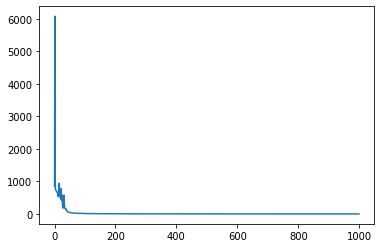

1.0
0.9877300613496932


In [58]:
def validate(A, Y):
    R = np.argmax(A, axis=1) == np.argmax(Y, axis=1)
    return np.sum(R) / R.size

np.random.shuffle(digits)
tr_ind = int(len(digits)*0.7)

# Normalize the values of the pixels to be between 0 and 1
X = digits[:, :-1] / 16

# Generate one-hot encoding for Y
Y = np.zeros((len(digits), 3))
Y[np.arange(len(digits)), digits[:, -1] - 1] = 1

X_train = X[:tr_ind]
X_test = X[tr_ind:]

Y_train = Y[:tr_ind]
Y_test = Y[tr_ind:]

Theta = n_layer_init(layer_sizes=(64, 65, 3))
Theta = two_layer_training(X_train, Y_train, Theta[0], Theta[1], 1000, 0.01)

A = n_layer_output(X_train, Theta)
print(validate(A, Y_train))

A = n_layer_output(X_test, Theta)
print(validate(A, Y_test))

### Training MLPClassifier [2 pts]

Compare your results from the previous section with using an existing implementation from scikit-learn: [MLPClassifier](http://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification). Read the documentation to figure out how to train this network. The full list of parameter options for the network can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). Try and see if you can find a set of parameters for this *Neural Network* that performs even better. Show the training and validation error for the best set of parameters you found and describe any additions you made to improve the performance. Keep in mind that the `MLPClassifier` does not accept one-hot encoded, we have therefore re-made the `Y_train` and `Y_test` variables.

In [59]:
from sklearn.neural_network import MLPClassifier

Y_train = digits[:tr_ind, -1]
Y_test = digits[tr_ind:, -1]

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(65,65))
clf.fit(X_train, Y_train)

print(clf.score(X_train, Y_train))
print(clf.score(X_test, Y_test))

1.0
0.9877300613496932
